In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import product
from joblib import Parallel, delayed
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def preprocess_data(df, features):

    print('\n----------Preprocessing Data----------')

    X = df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    return X_scaled, X_pca

In [6]:
def evaluate_clustering(model, X, labels):

    print('\n----------Evaluating Clusters----------')

    if len(set(labels)) > 1:
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
    else:
        silhouette, davies_bouldin = -1, -1

    wcss = np.sum((X - model.cluster_centers_[labels])**2) if hasattr(model, 'cluster_centers_') else None

    return silhouette, davies_bouldin, wcss

In [7]:
def optimize_kmeans(X):

    print('\n----------Optimizing K-Means----------')

    cluster_range = range(2, 6)
    best_k, best_kmeans, best_silhouette, best_wcss = None, None, -1, None

    for k in cluster_range:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=512)
        labels = kmeans.fit_predict(X)
        silhouette = silhouette_score(X, labels)
        wcss = kmeans.inertia_

        if silhouette > best_silhouette:
            best_k, best_kmeans, best_silhouette, best_wcss = k, kmeans, silhouette, wcss

    return best_k, best_kmeans, best_silhouette, best_wcss


In [8]:
def optimize_dbscan(X):

    print('\n----------Optimizing DB Scan----------')

    sample_size = min(5000, len(X))
    X_sampled = X[np.random.choice(len(X), sample_size, replace=False)]

    eps_values = [0.3, 0.5, 0.7]
    min_samples_values = [3, 5]

    def dbscan_fit(eps, min_samples):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=4)
        labels = dbscan.fit_predict(X_sampled)

        if len(set(labels)) > 1:
            silhouette = silhouette_score(X_sampled, labels)
            return eps, min_samples, silhouette, dbscan
        return eps, min_samples, -1, None

    results = Parallel(n_jobs=4)(delayed(dbscan_fit)(eps, min_samples) for eps, min_samples in product(eps_values, min_samples_values))
    best_result = max(results, key=lambda x: x[2])

    return {"eps": best_result[0], "min_samples": best_result[1]}, best_result[3], best_result[2]

In [9]:
def optimize_hierarchical(X):

    print('\n----------Optimizing Hierarichal Clustering----------')

    sample_size = min(3000, len(X))
    X_sampled = X[np.random.choice(len(X), sample_size, replace=False)]

    n_clusters_range = [3, 4, 5]
    linkage_options = ['ward', 'single']

    def hierarchical_fit(n_clusters, linkage):
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = hierarchical.fit_predict(X_sampled)

        if len(set(labels)) > 1:
            silhouette = silhouette_score(X_sampled, labels)
            return n_clusters, linkage, silhouette, hierarchical
        return n_clusters, linkage, -1, None

    results = [hierarchical_fit(n_clusters, linkage) for n_clusters, linkage in product(n_clusters_range, linkage_options)]

    best_result = max(results, key=lambda x: x[2])

    return {"n_clusters": best_result[0], "linkage": best_result[1]}, best_result[3], best_result[2]

In [10]:
def find_best_clustering_model(best_params, silhouette_scores, davies_scores, wcss_scores):

    model_scores = {
        model: silhouette_scores[model] - davies_scores[model] - (wcss_scores.get(model, 0) / 10000)
        for model in best_params.keys()
    }

    best_model = max(model_scores, key=model_scores.get)

    return best_model, best_params[best_model]

In [11]:
def run_clustering_pipeline(df, features):

    print('\n----------Running Clustering Pipeline & Selecting Best Model----------')

    X_scaled, X_pca = preprocess_data(df, features)

    best_k, best_kmeans, kmeans_score, best_wcss = optimize_kmeans(X_pca)
    best_dbscan_params, best_dbscan, dbscan_score = optimize_dbscan(X_scaled)
    best_hierarchical_params, best_hierarchical, hierarchical_score = optimize_hierarchical(X_pca)

    best_params_dict = {
        "K-Means": {"n_clusters": best_k, "wcss": best_wcss},
        "DBSCAN": best_dbscan_params,
        "Hierarchical": best_hierarchical_params
    }

    davies_scores = {
    "K-Means": davies_bouldin_score(X_pca, best_kmeans.labels_) if best_kmeans else float('inf'),

    "DBSCAN": (
        davies_bouldin_score(X_pca[:len(best_dbscan.labels_)][best_dbscan.labels_ != -1],
                             best_dbscan.labels_[best_dbscan.labels_ != -1])
        if best_dbscan and len(set(best_dbscan.labels_) - {-1}) > 1 else float('inf')
            ),

    "Hierarchical": (
        davies_bouldin_score(X_pca[:len(best_hierarchical.labels_)], best_hierarchical.labels_)
        if best_hierarchical else float('inf')
                )
    }

    results_df = pd.DataFrame({
        "K-Means": [f"{best_k} Clusters", kmeans_score, davies_scores["K-Means"], best_wcss],
        "DBSCAN": [best_dbscan_params, dbscan_score, davies_scores["DBSCAN"], None],
        "Hierarchical": [best_hierarchical_params, hierarchical_score, davies_scores["Hierarchical"], None]
    }, index=["Best Parameters", "Silhouette Score", "Davies-Bouldin Score", "WCSS"])

    print("\nClustering Optimization Results:")
    print(results_df)

    best_model_name, best_model_params = find_best_clustering_model(
        best_params_dict,
        {"K-Means": kmeans_score, "DBSCAN": dbscan_score, "Hierarchical": hierarchical_score},
        davies_scores,
        {"K-Means": best_wcss}
    )

    print(f"\nBest Clustering Model: {best_model_name} with Parameters: {best_model_params}")

    pickle_path = "/content/drive/MyDrive/ClickStream_Project/Pickles"

    os.makedirs(pickle_path, exist_ok=True)

    best_model_pickle_path = os.path.join(pickle_path, "best_model_clust.pkl")

    with open(best_model_pickle_path, "wb") as file:
        pickle.dump({"model_name": best_model_name, "params": best_model_params}, file)

    print(f"\nBest Model saved to '{best_model_pickle_path}'")

    return best_kmeans, best_dbscan, best_hierarchical, results_df, X_pca, best_model_name


In [12]:
def visualize_clusters(X_pca, labels, title="Clustering Visualization"):

    print('\n----------Visualizing Clusters----------')

    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

    if len(df_pca) == len(labels):
        df_pca['Cluster'] = labels
    else:
        print(f"\nMismatch detected! Adjusting data size. X_pca: {len(df_pca)}, labels: {len(labels)}")
        min_length = min(len(df_pca), len(labels))
        df_pca = df_pca.iloc[:min_length]
        df_pca['Cluster'] = labels[:min_length]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette="viridis")
    plt.title(title)
    plt.show()

    fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color=df_pca['Cluster'].astype(str), title=title)
    fig.show()


In [13]:
features = ['high_price_preference','page1_main_category','browsing_depth','unique_products','model_photography','colour','location','page','country']

In [14]:
df = pd.read_csv("/content/drive/MyDrive/ClickStream_Project/Preprocessed_Data/processed_data.csv")

In [15]:
best_kmeans, best_dbscan, best_hierarchical, results_df, X_pca, best_model_name = run_clustering_pipeline(df, features)


----------Running Clustering Pipeline & Selecting Best Model----------

----------Preprocessing Data----------

----------Optimizing K-Means----------

----------Optimizing DB Scan----------

----------Optimizing Hierarichal Clustering----------

Clustering Optimization Results:
                            K-Means                          DBSCAN  \
Best Parameters          2 Clusters  {'eps': 0.5, 'min_samples': 3}   
Silhouette Score           0.314088                        0.175547   
Davies-Bouldin Score       1.304785                       31.242666   
WCSS                  405545.762304                            None   

                                                Hierarchical  
Best Parameters       {'n_clusters': 3, 'linkage': 'single'}  
Silhouette Score                                    0.493218  
Davies-Bouldin Score                                2.597398  
WCSS                                                    None  

Best Clustering Model: Hierarchical with Parame

In [16]:
visualize_clusters(X_pca, best_kmeans.labels_, title="K-Means Clustering")

Output hidden; open in https://colab.research.google.com to view.

In [17]:
best_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)

In [18]:
visualize_clusters(X_pca, best_dbscan.labels_, title="DBSCAN Clustering")

Output hidden; open in https://colab.research.google.com to view.


----------Visualizing Clusters----------

Mismatch detected! Adjusting data size. X_pca: 132379, labels: 3000


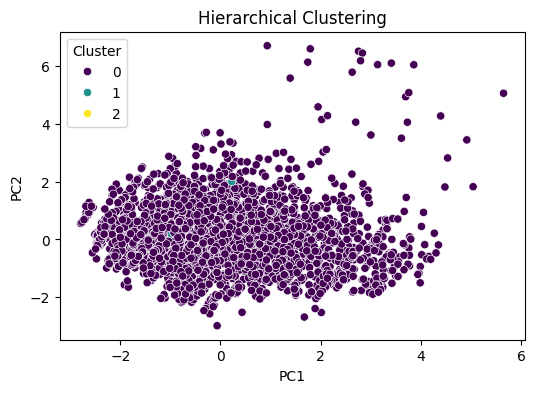

In [19]:
visualize_clusters(X_pca, best_hierarchical.labels_, title="Hierarchical Clustering")